# Machine Learning Project - Cryptocurrencies price variations prediction

In [1]:
#import usefull packages
import pandas as pd
import numpy as np
from numpy import absolute
import matplotlib.pyplot as plt
import glob
import ta
import collections
import sklearn
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



## See below for detailed steps of the following function (step by step, plots, comments...)

In [2]:
def features_selection(crypto_csv_file):
    
    
    # load data 
    Crypto = pd.read_csv(crypto_csv_file) 
    
    #get the name of the crypto 
    crypto_name = Crypto["Name"][0]
    #print(crypto_name)
    
    # Clean nan values
    Crypto = ta.utils.dropna(Crypto)

    # Add all technical analysis features filling nans values
    Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)
    
    # List of our indicators 
    indicators = ['volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']
    
    # compute the returns 
    Crypto["Returns"] = Crypto["Close"].pct_change()

    # keep only the relevant columns, ie. the ta indicators and the returns. 
    Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN
    
    # split into train and test sets
    Crypto_train, Crypto_test = train_test_split(Crypto,train_size = 0.80,random_state=None, shuffle=False)
    
    # standardize
    sc = StandardScaler()
    Z_Crypto_train = sc.fit_transform(Crypto_train)
    
    # Lasso regression (alpha = 1.0)
    from sklearn.linear_model import Lasso
    regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
    
    # Rename for clarity 
    # We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date
    X,y = pd.DataFrame(Z_Crypto_train[:-1,:-1]),pd.DataFrame(Z_Crypto_train[1:,-1:])
    
    # fit
    regLasso1.fit(X,y)
    
    # obtain coeffficients of the LASSO regression for multiple alphas
    from sklearn.linear_model import lasso_path
    alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)

    # number of non-nul coefficients for each alpha
    nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
    alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})
    
    # get the alpha for which we get 8 selected features (and its index)
    # If no such alpha exists, choose an alpha for which we get 7 selected features, etc...
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    while np.isnan(higher_alpha_to_get_8_features) == True :
        alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
        higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
    index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
        
    # get the 8 selected features coressponding 
    coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
    index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
    coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
    selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
    
    return crypto_name, selected_features
    
  

#### Run the Features Selection

In [3]:
# get a list of all csv files 
path = "/Users/nicolaspaganel/Desktop/GitHub/ML_Finance/Crypto df"
all_cryptos_csv_files = glob.glob(path + "/*.csv" )

# initialize dictionary with final selected features for each crypto
selected_features_per_crypto = {}

# get all selected features for each crpytocurrency 
for crypto_csv_file in all_cryptos_csv_files:
    
    crypto_name, features = features_selection(crypto_csv_file)
    
    # add selected features to the dictionray
    selected_features_per_crypto[crypto_name] = features
    

NEM


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2532143888513474, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2513331618365555, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7412460444186308, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7116383537866113, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6875272019090062, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7701108642756935, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7653787250160349, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7637358527454126, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0962698128184911, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0771179070802646, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0716639241470602, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0151142968697968, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0083498068045174, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0317626686942276, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0006664267220913, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9996753517921206, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9982893968599456, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.666552504269475, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.322633071061546, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.028980218409288, tolerance: 0.18289643053628127
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

EOS


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11858714386062275, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1903182174801259, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30812643392357586, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3069998891637624, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3058660819910983, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3915412802053879, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39430562624511367, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3934718754990172, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8741629198341343, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.842350538286496, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8129738400429005, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8766237174900198, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.905492823989448, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.36786584749757, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.16402405364875, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.18700759159697, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.15655170894024, tolerance: 0.11649682614682115
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

Monero


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20545124343220778, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29059382551372437, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5833896301546702, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7718894381114296, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9374060280015328, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.937759145279642, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.342782017528407, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.402498470753926, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.260612434188943, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.494722617321486, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.83981366549665, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.91217062812143, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138.96418759859034, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.01388300162807, tolerance: 0.2047906344571305
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

Polkadot


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02801864049169467, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03411412871281527, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04062495571281488, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23560922125909656, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23215701719843196, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23230067515061137, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6841403931888692, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6911825818312423, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6971526410906677, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6198471492723172, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6334036326414605, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6384275622226028, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3080557666745563, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5211375580238098, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.776734233413606, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.264627717850075, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.826543618299681, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.387656483208872, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.762878016312968, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.91027333608048, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.0436031156179, tolerance: 0.02439846786263492
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

USD Coin


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16364109532179327, tolerance: 0.07908488095124601
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14026957142829133, tolerance: 0.07908488095124601
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12645378384445394, tolerance: 0.07908488095124601
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

Uniswap


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.033847521230228494, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0336874999505028, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07608527676833887, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07353381450781171, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05235687871990535, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21444317982289363, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19842300792396372, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17240616629916872, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6652663603783537, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.859218963938531, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1087108064179745, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.542190356568995, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.874594213342107, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.209642669830714, tolerance: 0.02275619846687384
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

Binance Coin


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15792348432466952, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13384486122390626, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6059719665956891, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6182667621505971, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.619734635151417, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7845763123644929, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.765560681940542, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7559685935611924, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.041448031799519, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.552732520126142, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.788198964489538, tolerance: 0.11519533667073234
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

IOTA


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2286819576304424, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4602734197821974, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5746823779742272, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.589302189428281, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6148425553296875, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6260680043677667, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5231760209912864, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5573899167183072, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5655843291067413, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6134182015815668, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6216971823236008, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6215096965333942, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4145747442605625, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5695407370651537, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3241885635767403, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.51750131684139, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.67673270613477, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.72991739411657, tolerance: 0.11673400599471213
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

Aave


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025066390880539302, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03067988150408496, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03045097246999262, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3067248646650569, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2993298829113371, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2942851527586754, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7029221267587076, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7336849369582126, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7527784671617326, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3653214439523538, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.397702244140703, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2769524760902726, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.298029834435141, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.335364760006854, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3502182925194433, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.212724321827409, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2478121622887812, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.384580574351162, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.118385605476647, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.094081715493928, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.068270426161561, tolerance: 0.021722863145865825
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

Solana


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04156969575006997, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045390409735944104, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04649650438767594, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5420863099575968, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.522865436570612, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5154916972320223, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47834198465636746, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5943042317013578, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7395071735058991, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1597726740625944, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2023424744517968, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2360900828029457, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.683980105967862, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.551114903897883, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.466779402348294, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.35506457440481, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.15611653682325, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.94048850072609, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.254407186421645, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.452167640929375, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.63863381966058, tolerance: 0.03189417191153669
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

Bitcoin


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8409898128229543, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4684640111245244, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.389206887379032, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.823396033195877, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.1502844843118964, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.7665826258025845, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.244262542620163, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.630651164453184, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.965797425765004, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.89544351657628, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.89323778282619, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.57069812071836, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.530771438054217, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.502893406202475, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.46213142147417, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.0583458623903, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.53757169182836, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.00437149411232, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.3504644115976, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.59400464433725, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

Cardano


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1988395386214279, tolerance: 0.10924551763214954
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3127127443124209, tolerance: 0.10924551763214954
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.889126377468415, tolerance: 0.10924551763214954
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7984209233078445, tolerance: 0.10924551763214954
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.06018221922659, tolerance: 0.10924551763214954
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.783673247055958, tolerance: 0.10924551763214954
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.81445565843967, tolerance: 0.10924551763214954
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8024637595802915, tolerance: 0.10924551763214954
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

Tether


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Cosmos


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13366601346194784, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1569141498589488, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sk

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3757324816916707, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3747337473258767, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38834625726985905, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.627558151815606, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.032436761767087, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.379597996849554, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.501270187887826, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.467995648167175, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.417775305035434, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.377610061242649, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.441251202195303, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.497795315002861, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.532139400546328, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.515761489033821, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.495887603852168, tolerance: 0.0634779071581099
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

Chainlink


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1361431917854361, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13372464573342313, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4878672291223438, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5826018599884719, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.656525281723134, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3424916568071694, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3151086856668144, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.284816834272533, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.887432289920753, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.545265524619936, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4904691095454154, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.877015324772628, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.882502373660031, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.87349312236006, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.41543446664923, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.440542734833798, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.42798638739123, tolerance: 0.11048345174025054
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

Litecoin


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5952098919326545, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8120537654331201, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0201621388118838, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0181020219583843, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0160463602330765, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7781431606069873, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.136497110946493, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.357343100195294, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.755269258221233, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.708120953540401, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.094647570989309, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.14649161701368, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.494431983628374, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.45552022001607, tolerance: 0.21976983529809468
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

XRP


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.845091183591876, tolerance: 0.21979953957586432
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2104138894676453, tolerance: 0.21979953957586432
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sk

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.668299148421283, tolerance: 0.21979953957586432
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.699426045114706, tolerance: 0.21979953957586432
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.90325059409133, tolerance: 0.21979953957586432
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.77778721847494, tolerance: 0.21979953957586432
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114.1413429867714, tolerance: 0.21979953957586432
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.48676839106997, tolerance: 0.21979953957586432
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

Ethereum


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18579009069503627, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4280482813726394, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5389386641211331, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5125886268567683, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4938887299792896, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2966115976328183, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.318426162863716, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3332953525048197, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1822984528942015, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.012553092745293, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.847657806717052, tolerance: 0.17257313923462322
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

TRON


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16018093009176937, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11681665938408514, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1164983466293279, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2123682631106476, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21062729460470564, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20883242320451245, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17510315295464807, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17343060761993456, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17177016243863363, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11733550172243667, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1161674479994872, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11501062286731667, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21237917551741248, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19037506455026687, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1812072023416249, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.582988442553301, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.603310246540218, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6136997209259789, tolerance: 0.10894872889617314
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

Stellar


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3241266551517583, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36944280905095184, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4073596921400622, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6013157649526875, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.572163520518643, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5922613548889331, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9924471306389933, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1726137529633434, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2912512939462886, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.449905508711254, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4235888502366834, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3990880778233077, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.012397678966408, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.91955249069224, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.8029673982885, tolerance: 0.20194159955841626
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

Crypto.com Coin


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08279240610448824, tolerance: 0.0742782616691907
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08478262333511566, tolerance: 0.0742782616691907
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0747660993442878, tolerance: 0.0742782616691907
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.25315793032712, tolerance: 0.0742782616691907
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2591466221915084, tolerance: 0.0742782616691907
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2486304674180246, tolerance: 0.0742782616691907
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.026331921094879, tolerance: 0.0742782616691907
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.375024454020661, tolerance: 0.0742782616691907
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.706083689810669, tolerance: 0.0742782616691907
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordina

Dogecoin


/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22559947646027467, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25098809816745415, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/s

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5043907984295402, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5021412518026409, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49986744218131207, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7130346556407403, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.739517821801428, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7502211083515249, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.02014549265914, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.657848308495431, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.147164383673953, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinat

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.869560747154992, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.366495360628733, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.948254202789258, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coord

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.6318737817669, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.730103811113395, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.908336030247483, tolerance: 0.2194963438877146
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

Wrapped Bitcoin


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11081016967216328, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20857472697383628, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36028236845879746, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mod

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.098879349378308, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.136056348128875, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0532486916904418, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7779612092667776, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7183035260506472, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6780014114849564, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3636963056747504, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.593272079040389, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.836011881078548, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.84126858777097, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.524037140153325, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.51732345415354, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.922087191409105, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.614212166945777, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.291768208146607, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.492458374169587, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.98309612669709, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.49167158889992, tolerance: 0.055198042073709624
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_c

#### Retults of the Features Selection

In [13]:
# Results as table
pd.set_option("display.max_columns", 100)
Table_Selected_Features = pd.DataFrame({ key:pd.Series(value) for key, value in selected_features_per_crypto.items() }).fillna("NaN")
Table_Selected_Features.index.name = 'Features'
Table_Selected_Features.index += 1
Table_Selected_Features




,NEM,EOS,Monero,Polkadot,USD Coin,Uniswap,Binance Coin,IOTA,Aave,Solana,Bitcoin,Cardano,Tether,Cosmos,Chainlink,Litecoin,XRP,Ethereum,TRON,Stellar,Crypto.com Coin,Dogecoin,Wrapped Bitcoin
Features,,,,,,,,,,,,,,,,,,,,,,,
1,volume_adi,volume_obv,volume_obv,volume_obv,volume_fi,volume_sma_em,volume_nvi,volume_obv,volume_sma_em,volatility_kcw,volume_em,volume_nvi,volume_em,volume_em,volatility_kchi,volume_em,volume_nvi,volatility_bbp,volume_nvi,volume_em,volume_adi,volume_mfi,volume_obv
2,volume_vpt,volume_fi,volume_fi,volatility_kcw,volume_vpt,volatility_bbw,volatility_bbhi,volume_vpt,volatility_kcw,volatility_kchi,volatility_bbl,volatility_bbhi,trend_macd_diff,volatility_bbli,trend_vortex_ind_pos,volume_sma_em,volatility_bbhi,volatility_bbhi,volatility_bbw,volatility_bbli,volume_vpt,volatility_bbhi,volatility_bbw
3,trend_adx,volatility_bbl,volume_vpt,volatility_kcli,volatility_bbp,trend_mass_index,volatility_dcw,volatility_bbl,trend_mass_index,trend_adx_pos,volatility_bbw,volatility_dcl,trend_sma_slow,volatility_kcli,trend_vortex_ind_neg,volatility_bbl,volatility_kcw,volatility_kcw,volatility_bbhi,volatility_kcw,volatility_bbhi,volatility_kcw,volatility_kchi
4,trend_aroon_up,volatility_bbw,volatility_kchi,trend_mass_index,volatility_kchi,trend_visual_ichimoku_b,trend_kst_sig,volatility_bbw,trend_visual_ichimoku_a,trend_adx_neg,volatility_kchi,trend_adx,trend_ema_fast,trend_dpo,trend_mass_index,volatility_bbhi,volatility_kchi,volatility_kchi,volatility_dcl,trend_adx,trend_mass_index,volatility_dcl,trend_adx
5,trend_psar_down_indicator,trend_adx,trend_mass_index,trend_kst_sig,trend_kst_sig,trend_psar_down_indicator,trend_ichimoku_b,volatility_kcw,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_up,trend_cci,trend_kst_diff,trend_psar_up,trend_cci,volatility_bbli,trend_adx,volatility_dcl,trend_mass_index,trend_vortex_ind_neg,trend_psar_up,volatility_dcp,trend_adx_neg
6,momentum_tsi,trend_kst_sig,trend_stc,trend_kst_diff,trend_visual_ichimoku_a,trend_stc,momentum_uo,volatility_kchi,trend_aroon_down,trend_psar_down_indicator,momentum_stoch_rsi,trend_dpo,trend_psar_down,trend_psar_up_indicator,trend_dpo,trend_adx,trend_psar_down,volatility_dcp,trend_dpo,trend_psar_up,momentum_rsi,trend_dpo,trend_aroon_up
7,others_dlr,trend_aroon_up,momentum_tsi,trend_psar_down_indicator,others_dr,others_dr,momentum_ppo,volatility_dcw,trend_psar_up_indicator,momentum_roc,momentum_stoch,trend_kst_sig,momentum_ao,momentum_stoch_rsi_d,trend_stc,momentum_tsi,momentum_rsi,trend_adx,trend_ichimoku_a,trend_stc,momentum_ppo,trend_ichimoku_base,trend_psar_up_indicator
8,NaN,momentum_tsi,momentum_ppo,momentum_ppo,others_cr,others_dlr,others_dr,momentum_ppo,others_dr,others_dlr,momentum_wr,momentum_ppo_hist,others_cr,others_dlr,others_dlr,momentum_uo,momentum_stoch,trend_aroon_up,trend_psar_up,others_dr,momentum_ppo_hist,others_dr,others_dlr


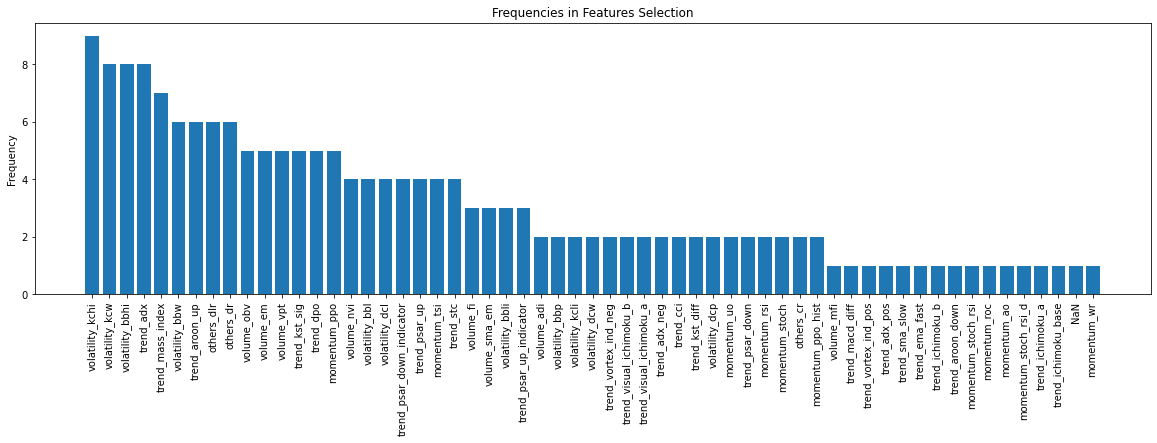

In [14]:
# Plot the dsitribution of apparition of the different features 
liste = Table_Selected_Features.values.tolist()
full_liste = []
for i in range(len(liste)):
    for j in range(len(liste[i])):
        full_liste.append(liste[i][j])
        
occurrences = collections.Counter(full_liste)
y = [count for tag, count in occurrences.most_common()]
x = [tag for tag, count in occurrences.most_common()]

f, ax = plt.subplots(figsize=(20,5))
plt.bar(x, y)
plt.title("Frequencies in Features Selection")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()


## DETAILED STEPS of the Features Selection function

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


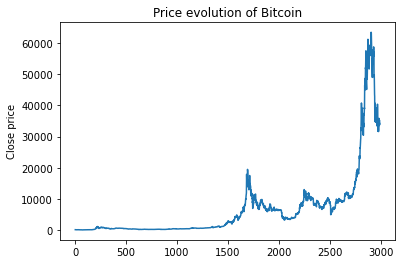

In [15]:
# load data 

Crypto = pd.read_csv("/Users/nicolaspaganel/Desktop/GitHub/ML_Finance/Crypto df/coin_Bitcoin.csv") 

# let's have a look at the data
plt.plot(Crypto["Close"])
plt.ylabel("Close price")
crypto_name = Crypto["Name"][0]
plt.title("Price evolution of " + crypto_name)
Crypto.head()

In [16]:
# Clean nan values

Crypto = ta.utils.dropna(Crypto)

# Add all technical analysis features filling nans values

Crypto = ta.add_all_ta_features(Crypto, "Open", "High", "Low", "Close", "Volume", fillna=True)

#print(Cardano.columns)

/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [17]:
# List of our indicators 

indicators = ['volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [18]:
# compute the returns 

Crypto["Returns"] = Crypto["Close"].pct_change()

# keep only the relevant columns, ie. the ta indicators and the returns. 

Crypto = Crypto[indicators].join(Crypto["Returns"]).iloc[1: , :] #drop the first row as return = NaN

Crypto

,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,Returns
243,-1.284359e+07,1.435690e+07,-0.161822,-2.353417e+08,0.000000,-2482.908219,-2482.908219,-4.245126e+07,990.150611,735.788338,0.000000,731.450012,738.690002,724.210022,1.979627,0.250000,0.0,0.0,734.403330,787.213359,681.593302,14.381751,0.437765,0.0,0.0,705.349976,777.510010,741.429993,9.865340,0.311530,0.000000,-0.577549,-0.115510,-0.462039,731.450012,731.450012,733.956163,734.533712,0.000000,0.000000,0.000000,0.005063,0.010919,-0.005856,-0.001924,1.943639,-66.666667,6548.822214,-899.529854,-899.281237,-0.248617,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,4.0,8.0,-4.0,-1.000000,-1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,21.283876,31.153036,32.373592,-68.846964,0.000000,731.817595,0.000000,-2.500653,-0.500131,-2.000522,-0.984939,-0.989821,-0.984939,-0.009849
244,2.206332e+06,3.336820e+07,0.022427,-1.549537e+08,37.199037,956.192156,-763.358031,1.296324e+05,1013.576912,735.835681,0.000000,735.983337,750.102589,721.864086,3.836840,0.821074,0.0,0.0,734.946662,781.543342,688.349982,12.680289,0.608413,0.0,0.0,705.349976,777.510010,741.429993,9.804574,0.550166,0.000000,0.350210,-0.022366,0.372576,735.983337,735.983337,735.662905,735.312695,0.000000,0.000000,0.000000,0.011550,0.015774,-0.004224,-0.000474,2.831246,13.251992,6544.288889,-898.907168,-899.156548,0.249380,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,12.0,8.0,4.0,-1.000000,777.510010,0.0,1.0,0.000000,71.921234,0.000000,0.000000,0.000000,-94.850634,37.978405,55.016621,39.921268,-44.983379,0.000000,738.216009,0.000000,-7.088933,-1.817891,-5.271042,2.365933,2.338379,1.357691,0.023659
245,6.464174e+06,5.407590e+07,0.054281,-1.000401e+08,55.625599,2787.135170,420.139703,7.577494e+05,1013.576912,739.050431,0.000000,741.020004,762.325663,719.714345,5.750360,0.854601,0.0,0.0,739.790827,781.328334,698.253321,11.229527,0.696680,0.0,0.0,705.349976,777.510010,741.429993,9.737933,0.703714,0.000000,1.956971,0.373502,1.583470,741.020004,741.020004,738.811690,736.854718,0.000000,0.000000,0.000000,0.019325,0.016967,0.002359,0.006118,3.661183,115.325833,6539.252222,-898.215344,-898.921247,0.705903,741.429993,741.429993,741.429993,741.429993,7158.248889,7044.852011,16.0,8.0,8.0,-1.000000,776.248610,0.0,0.0,0.000000,81.260429,0.000000,0.000000,0.000000,-87.732937,41.516721,70.371404,52.180354,-29.628596,0.000000,746.502271,0.000000,-10.620253,-3.578364,-7.041890,1.487151,1.476201,2.865033,0.014872
246,1.510844e+07,3.317860e+07,0.107929,-9.207753e+07,42.962004,-433.779509,206.659900,2.493640e+05,1013.576912,740.822352,0.000000,743.618005,765.323734,721.912277,5.837871,0.739384,0.0,0.0,742.016663,779.728674,704.304651,10.164734,0.659012,0.0,0.0,705.349976,777.510010,741.429993,9.7

In [19]:
## look at the correlations between the features and the returns

#pd.DataFrame(np.corrcoef(Crypto, rowvar=False))

# if a coefficient is > 0.9 , drop it

#######                     #######
####### CODE GENERALIZATION #######
#######                     #######


#(so far, we did it manually, not good)



In [20]:
# split into train and test sets

Crypto_train, Crypto_test = train_test_split(Crypto,train_size = 0.80,random_state=None, shuffle=False)

In [21]:
# standardize

sc = StandardScaler()
Z_Crypto_train = sc.fit_transform(Crypto_train)

In [22]:
# Lasso regression (alpha = 1.0)

from sklearn.linear_model import Lasso
regLasso1 = Lasso(fit_intercept=False,normalize=False, max_iter=1000)
#print(regLasso1)

In [23]:
# Rename for clarity 
# We use Features from t=0 to t=T-1 to predict Returns from t=1 to t=T, where T is the final observation date

X,y = pd.DataFrame(Z_Crypto_train[:-1,:-1]),pd.DataFrame(Z_Crypto_train[1:,-1:])

In [24]:
# fit

regLasso1.fit(X,y)

Lasso(fit_intercept=False)

In [25]:
# obtain coeffficients of the LASSO regression for multiple alphas

from sklearn.linear_model import lasso_path
alpha_for_path, coefs_lasso, _ = lasso_path(X,y,n_alphas=500)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8409898128229543, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4684640111245244, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8972506865425203, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_co

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.389206887379032, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.823396033195877, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.1502844843118964, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.7665826258025845, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.244262542620163, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.630651164453184, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.965797425765004, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.89544351657628, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.89323778282619, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.57069812071836, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.530771438054217, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.502893406202475, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.46213142147417, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.0583458623903, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.53757169182836, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordi

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.00437149411232, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128.3504644115976, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:517: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.59400464433725, tolerance: 0.21979099736407012
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coo

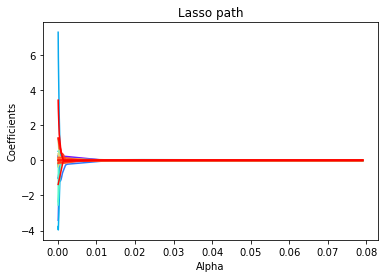

In [26]:
# graph of lasso path (coefficients given alpha)
import matplotlib.cm as cm
couleurs = cm.rainbow(np.linspace(0,1,len(indicators)))
for i in range(coefs_lasso.shape[1]):
    plt.plot(alpha_for_path,coefs_lasso[0][i,:],c=couleurs[i])
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.show()

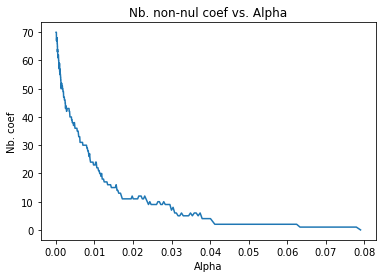

In [27]:
# number of non-nul coefficients for each alpha

nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso[0],axis=0)
alphas_nnz_df = pd.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero})

plt.plot(alpha_for_path,nbNonZero)
plt.xlabel('Alpha')
plt.ylabel('Nb. coef') 
plt.title('Nb. non-nul coef vs. Alpha') 
plt.show()

In [28]:
# get the alpha for which we get 8 selected features (and its index)
# If no such alpha exists, choose an alpha for which we get 7 selected features, etc...

alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 8 ]
higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
while np.isnan(higher_alpha_to_get_8_features) == True :
    alphas_to_get_8_features = alphas_nnz_df.loc[alphas_nnz_df['Nb non-zero coefs'] == 7 ]
    higher_alpha_to_get_8_features = alphas_to_get_8_features.max()[0]
index_higher_alpha_to_get_8_features = list(alpha_for_path).index(higher_alpha_to_get_8_features)  
#index_higher_alpha_to_get_8_features

In [29]:
# get the 8 selected features coressponding 

coefs_at_higher_alpha_to_get_8_features = coefs_lasso[0][:,index_higher_alpha_to_get_8_features]
index_coefs_at_higher_alpha_to_get_8_features = coefs_at_higher_alpha_to_get_8_features.nonzero()[0]
coefs_lasso[0][:,[index_higher_alpha_to_get_8_features,2]]
selected_features = [indicators[i] for i in index_coefs_at_higher_alpha_to_get_8_features]
selected_features

['volume_em',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_kchi',
 'trend_aroon_up',
 'momentum_stoch_rsi',
 'momentum_stoch',
 'momentum_wr']